# Triangulation analysis with world coordinates (Fundamental Matrix)
## Usage
This code will go through the analysis of the 3d scenes we have both in controlled setting and real setting, to investigate the 3D reconstruction efficacy of pose estimated keypoints

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- `numpy`
- `PIL`

#### Common imports

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

#### Part 1: Prepare some functions

In [2]:
def get_residual(F, p1, p2):
    """
    Function to compute the residual average residual on frame 2
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    """
    P1 = np.c_[p1, np.ones((p1.shape[0],1))].transpose()
    P2 = np.c_[p2, np.ones((p2.shape[0],1))].transpose()
    L2 = np.matmul(F, P1).transpose()
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis = 1)
    return np.mean(np.square(pt_line_dist))

def plot_fundamental(ax, F, p1, p2, I):
    """
    Function to display epipolar lines and corresponding points
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    param: I: frame 2
    """
    N = p1.shape[0]
    P1 = np.c_[p1, np.ones((N,1))].transpose()
    P2 = np.c_[p2, np.ones((N,1))].transpose()
    L2 = np.matmul(F, P1).transpose() # transform points from 

    # the first image to get epipolar lines in the second image
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis=1)
    closest_pt = p2 - (L2[:,0:2]*pt_line_dist[:,np.newaxis])

    # Find endpoints of segment on epipolar line (for display purposes).
    # offset from the closest point is 10 pixels
    pt1 = closest_pt - np.c_[L2[:,1], -L2[:,0]]*10
    pt2 = closest_pt + np.c_[L2[:,1], -L2[:,0]]*10

    # Display points and segments of corresponding epipolar lines.
    # You will see points in red corsses, epipolar lines in green 
    # and a short cyan line that denotes the shortest distance between
    # the epipolar line and the corresponding point.
    ax.set_aspect('equal')
    ax.imshow(np.array(I))
    ax.plot(p2[:,0],p2[:,1],  '+r')
    ax.plot([p2[:,0], closest_pt[:,0]],[p2[:,1], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
# write your code here for part estimating essential matrices
def fit_fundamental(matches):
    """
    Solves for the fundamental matrix using the matches with unnormalized method.
    param matches: N by 4 matrix where each row is [x, y, x', y']
    """
    
    #select 8 random points from the matches? 
    # np.random.shuffle(matches)
    # eight_points = matches[:8, :] # 8 by 4
    p1 = np.c_[matches[:, :2], np.ones((matches.shape[0],1))] #get points from img1 N by 2
    p2 = np.c_[matches[:, 2:], np.ones((matches.shape[0],1))] #get points from img2 N by 2
    u = p1[:,0]
    uprime = p2[:, 0]
    v = p1[:,1]
    vprime = p2[:, 1]

    A = np.c_[uprime*u, uprime*v, uprime, vprime*u, vprime*v, vprime, u, v, np.ones((matches.shape[0], 1))]

    #now its AF = 0 where we can do least square solution, ||AF||

    u, s, vT = np.linalg.svd(A)
    F = vT[-1].reshape(3,3)


    #Enforce rank2 
    u_, s_, vt_ = np.linalg.svd(F)
    s_[-1] = 0
    F = u_.dot(np.diag(s_).dot(vt_))
    return F / F[2,2]

def fit_fundamental_normalized(matches, I1_shape, I2_shape):
    """
    Solve for the fundamental matrix using the matches with normalized method.
    """

    # <YOUR CODE>
    # np.random.shuffle(matches)
    # eight_points = matches[:8, :] # 8 by 4
    p1 = np.c_[matches[:, :2], np.ones((matches.shape[0],1))] #get points from img1 N by 2
    p2 = np.c_[matches[:, 2:], np.ones((matches.shape[0],1))] #get points from img2 N by 2

    p1_avg = np.mean(p1, axis=0) #xavg,yavg
    p2_avg = np.mean(p2, axis=0) #xavg,yavg

    # print(f'p1avg is {p1_avg}')

    # p1 /= np.array([I1_shape[0], I1_shape[1], 1])
    # p2 /= np.array([I1_shape[0], I1_shape[1], 1])
    msd1 = np.average(np.sum(np.square(p1 - p1_avg), axis=1))
    msd2 = np.average(np.sum(np.square(p2 - p2_avg), axis=1))
    
    p1 -= np.array([p1_avg[0], p1_avg[1], 0])
    p2 -= np.array([p2_avg[0], p2_avg[1], 0])

    factor1 = np.sqrt(2 / msd1)
    factor2 = np.sqrt(2 / msd2)

    p1 *= factor1
    p2 *= factor2

    #construct T matrix does translation and the factor
    T1 = np.diag(np.array([factor1, factor1, factor1]))
    T1[2,2] = 1
    T1[0,2] = -p1_avg[0]*factor1
    T1[1,2] = -p1_avg[1]*factor1
    T2 = np.diag(np.array([factor2, factor2, factor2]))
    T2[2,2] = 1
    T2[0,2] = -p2_avg[0]*factor2
    T2[1,2] = -p2_avg[1]*factor2
    u = p1[:,0]
    uprime = p2[:, 0]
    v = p1[:,1]
    vprime = p2[:, 1]

    A = np.c_[uprime*u, uprime*v, uprime, vprime*u, vprime*v, vprime, u, v, np.ones((matches.shape[0], 1))]

    #now its AF = 0 where we can do least square solution, ||AF||

    u, s, vT = np.linalg.svd(A)
    F = vT[-1].reshape(3,3)

    #Enforce rank2 
    u_, s_, vt_ = np.linalg.svd(F)
    s_[-1] = 0
    F = u_.dot(np.diag(s_).dot(vt_))

    return T2.T @ F @ T1

#### Part 2: Prepare data

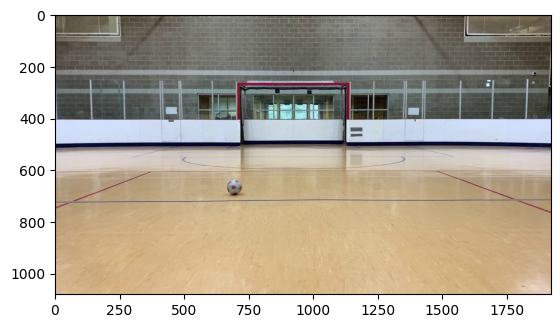

In [3]:
# Fundamental matrix estimation
name = 'example_files/library' 

vid_type = input("Please insert your desired video type, either (0) studio or (1) real (futsal) setting:")

if(int(vid_type) == 1):
    vid = input("Input video numbers 674,679,687,688,689:")
    vid = int(vid)
    if(vid % 1 != 0 or vid > 692 or vid < 674):
        print("invalid video number")
    else:
        vid1 = str(vid)
        vid2 = str(vid+1684)

        I1 = Image.open('revised_videos/frames/0' + vid1 + '_frames/f0001.jpg')
        I2 = Image.open('revised_videos/frames/' + vid2 + '_frames/f0001.jpg')
        matches = np.loadtxt('./{:s}_matches.txt'.format(name))

        ## matches are in the format of (I1 key point, I2 keypoint)

        N = len(matches)

        plt.imshow(I1)

elif(int(vid_type) == 0 ):
    print('not available')

##### Select the number of points you will use to find the fundamental matrix (should be more than or equal to 8)

In [4]:
fundamental_points = 9

##### Plot the first view

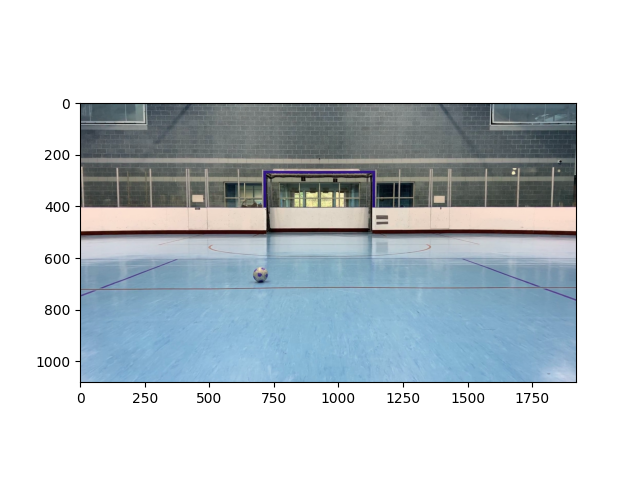

you clicked MouseButton.LEFT 722.7896092849942 503.00429812123366
you clicked MouseButton.LEFT 722.7896092849942 265.92524813895784
you clicked MouseButton.LEFT 1131.1554370056604 267.05959766040405
you clicked MouseButton.LEFT 1132.2897865271068 499.6012495568948
you clicked MouseButton.LEFT 1485.0724876969048 599.4240074441686
you clicked MouseButton.LEFT 375.67865572242766 602.8270560085075
you clicked MouseButton.LEFT 483.4418602598258 497.33255051400215
you clicked MouseButton.LEFT 481.17316121693324 399.77849166962073
you clicked MouseButton.LEFT 1542.9243132906659 544.9752304147464


In [5]:
%matplotlib widget
# frame = input("Input the video you want to use (Select from 679, 687, 688, 689)")
im = cv2.imread("revised_videos/frames/0" + vid1 + "_frames/f0012.jpg")
# im = cv2.imread("revised_videos/frames/2363_frames/f0016.jpg")

coordinates = []
curr_background_kp_1 = "background_keypoints_angle1_" + vid1 + ".txt"


def on_click(event):
    # save point
    x, y = event.xdata, event.ydata
    coordinates.append((event.xdata, event.ydata))
    ax.scatter(x, y, color='red')
    fig.canvas.draw()
    print('you clicked', event.button, event.xdata, event.ydata)

    if len(coordinates) == fundamental_points:
        f = open("background_keypoints_angle1_" + vid1 + ".txt", "w")
        for i in range(fundamental_points):
            plt.plot(coordinates[i][0], coordinates[i][1], 'o', color='r')
            f.write(str(coordinates[i][0]) + "," + str(coordinates[i][1])+ "\n")

        fig.canvas.mpl_disconnect(cid)
    return coordinates

fig, ax = plt.subplots()
ax.imshow(im)

cid = fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()

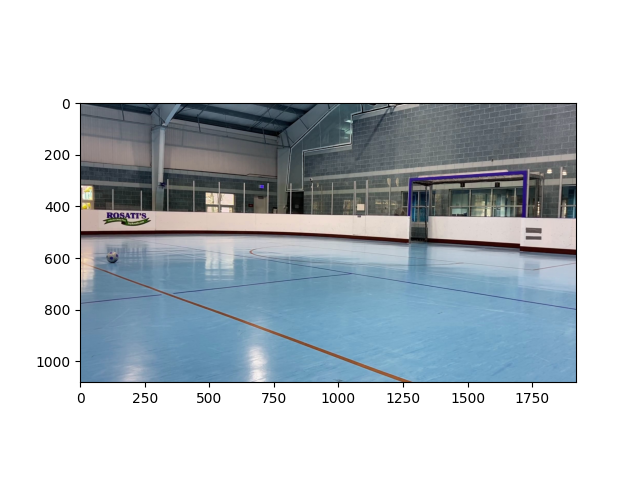

you clicked MouseButton.LEFT 1272.4049247542343 543.2332964507618
you clicked MouseButton.LEFT 1284.3889233924162 300.28496042216375
you clicked MouseButton.LEFT 1712.5445111020085 274.1380543024941
you clicked MouseButton.LEFT 1700.5605124638266 569.3802025704317
you clicked MouseButton.LEFT 1047.9773138937355 658.71546514597
you clicked MouseButton.LEFT 445.5090187196782 565.02238488382
you clicked MouseButton.LEFT 1098.0922172897692 523.6231168610095
you clicked MouseButton.LEFT 1101.360580554728 437.5562175504299
you clicked MouseButton.LEFT 1753.943779124819 647.820920929441


In [6]:
%matplotlib widget
# frame = input("Input the video you want to use (Select from 679, 687, 688, 689)")
im = cv2.imread("revised_videos/frames/" + vid2 + "_frames/f0016.jpg")
# im = cv2.imread("revised_videos/frames/2363_frames/f0016.jpg")

coordinates = []

curr_background_kp_2 = "background_keypoints_angle2_" + vid1 + ".txt"
def on_click(event):
    # save point
    x, y = event.xdata, event.ydata
    coordinates.append((event.xdata, event.ydata))
    ax.scatter(x, y, color='red')
    fig.canvas.draw()
    print('you clicked', event.button, event.xdata, event.ydata)

    if len(coordinates) == fundamental_points:
        f = open(curr_background_kp_2, "w")
        for i in range(fundamental_points):
            plt.plot(coordinates[i][0], coordinates[i][1], 'o', color='r')
            f.write(str(coordinates[i][0]) + "," + str(coordinates[i][1])+ "\n")

        fig.canvas.mpl_disconnect(cid)
    return coordinates

# def on_click(event):
#     coordinates.append((event.xdata, event.ydata))
#     print('you clicked', event.button, event.xdata, event.ydata)

#     if len(coordinates) == 8:
#         f = open(curr_background_kp_2, "w")
#         for i in range(8):
#             f.write(str(coordinates[i][0]) + "," + str(coordinates[i][1])+ "\n")

#         fig.canvas.mpl_disconnect(cid)
#     return coordinates

fig, ax = plt.subplots()
ax.imshow(im)

cid = fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()

In [7]:
def read_text(dir):
    f = open(dir, 'r')
    coordinates = np.zeros((fundamental_points,2))
    for idx, line in enumerate(f):
        x, y = line.split(',')
        coordinates[idx][0] = float(x)
        coordinates[idx][1] = float(y)

    return coordinates

def create_match_text(dir1, dir2, output):
    coord1 = read_text(dir1)
    coord2 = read_text(dir2)
    
    match_coordinates = np.zeros((fundamental_points,4))
    f = open(output, 'w')
    for i in range(fundamental_points):
        f.write(str(coord1[i][0])+ " " + str(coord1[i][1])+ " " + str(coord2[i][0]) + " " + str(coord2[i][1])+ "\n")
        # x, y = line.split(',')
        # coordinates[idx][0] = float(x)
        # coordinates[idx][1] = float(y)

    return 


create_match_text(curr_background_kp_1, curr_background_kp_2, "custom_match.txt")

matches = np.loadtxt("custom_match.txt")

example_files/library: residual in frame 2 (non-normalized method) =  1632.0458479803046
example_files/library: residual in frame 1 (non-normalized method) =  1301.119287669596
example_files/library: residual combined   (non-normalized method) =  1466.5825678249503
Fundamental matrix without normalization 
 [[ 1.51872443e-07  1.87699786e-06 -8.74210138e-04]
 [ 2.21798597e-07 -1.38007499e-06 -3.62544343e-03]
 [ 2.00859814e-05  2.20581480e-03  1.00000000e+00]]

Fundamental matrix with normalization 
 [[ 5.34089511e-08  1.11272008e-06 -5.57000798e-04]
 [ 1.78704530e-07 -8.19316427e-07 -2.14716799e-03]
 [-4.79196415e-05  1.30958534e-03  6.43775586e-01]]
example_files/library: residual in frame 2 (normalized method) =  13.004403238558403
example_files/library: residual in frame 1 (normalized method) =  31.174098791641736
example_files/library: residual combined   (normalized method) =  22.089251015100068


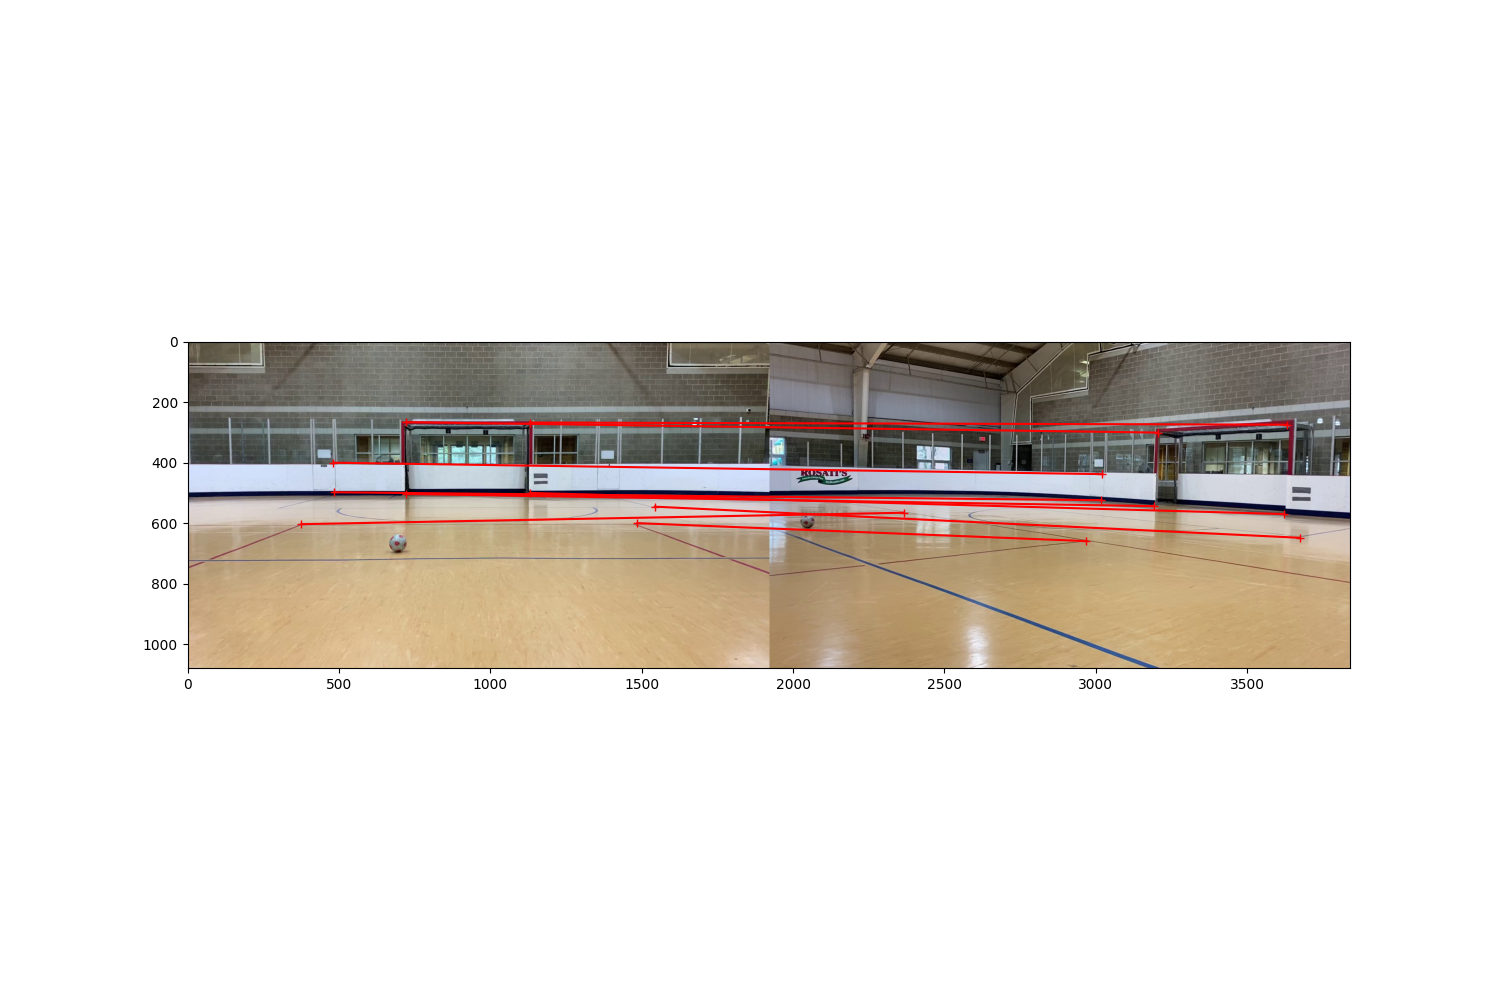

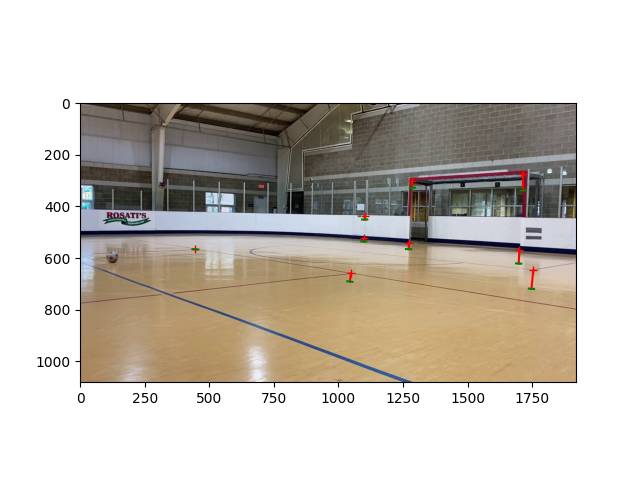

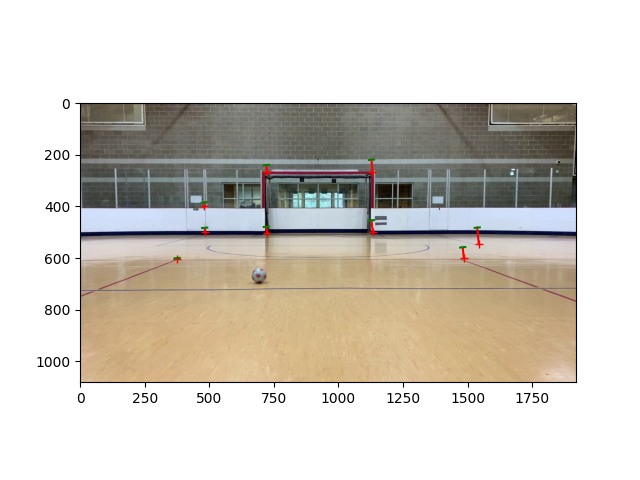

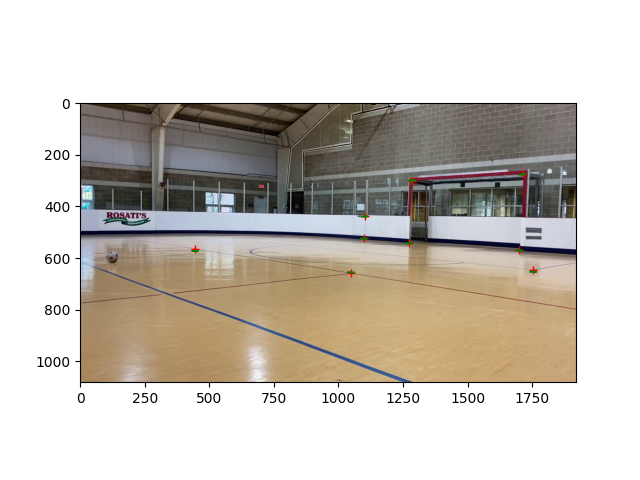

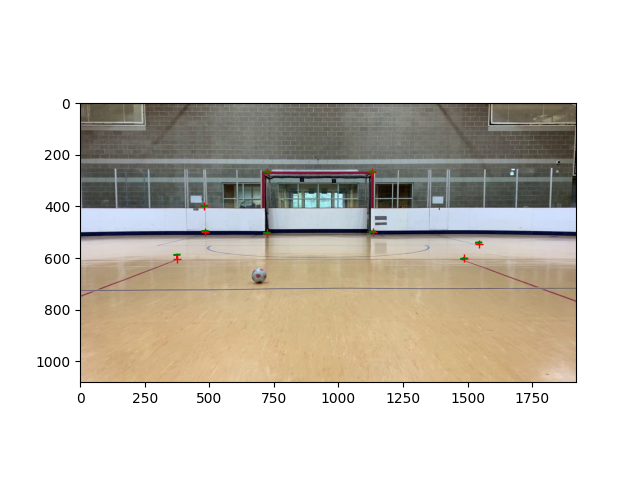

In [8]:
## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1
I3[:,I1.size[0]:,:] = I2
fig, ax = plt.subplots(figsize=(15,10))
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))

# non-normalized method
FN = fit_fundamental(matches) # <YOUR CODE>
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(FN, pt1_2d, pt2_2d)
v1 = get_residual(FN.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (non-normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (non-normalized method) = '.format(name), v1)
print('{:s}: residual combined   (non-normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, FN, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, FN.T, pt2_2d, pt1_2d, I1)
print(f'Fundamental matrix without normalization \n {FN}')

# normalized method
F = fit_fundamental_normalized(matches, I1.size, I2.size) # <YOUR CODE>
print("")
print(f'Fundamental matrix with normalization \n {F}')

pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)

#### Part 3: Finding key metrics such as Fundamental Matrix and Camera Projection Matrix

In [9]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

# Write your code here for camera calibration
def camera_calibration(matches, pts_3d):
    """
    write your code to compute camera matrix
    """
    # <YOUR CODE>
    #matches 20 by 4
    #pts_3d 20 by 3

    #[0,0,0,x,y,z,-xy',-yy',-zy']
    #[x,y,z,0,0,0,-xx',-yx',-zx']

    first = np.array([0, 0, 0, 0, pts_3d[0, 0], pts_3d[0, 1], pts_3d[0, 2], 1, -matches[0, 1]*pts_3d[0, 0], -matches[0, 1]*pts_3d[0, 1], -matches[0, 1]*pts_3d[0, 2], -matches[0, 1]])
    second = np.array([pts_3d[0, 0], pts_3d[0, 1], pts_3d[0, 2], 1, 0, 0, 0, 0, -matches[0, 0]*pts_3d[0, 0], -matches[0, 0]*pts_3d[0, 1], -matches[0, 0]*pts_3d[0, 2], -matches[0, 0]])
    A = np.r_[[first], [second]]
    
    for n in range(1, matches.shape[0]):
        first = np.array([0, 0, 0, 0, pts_3d[n, 0], pts_3d[n, 1], pts_3d[n, 2], 1, -matches[n, 1]*pts_3d[n, 0], -matches[n, 1]*pts_3d[n, 1], -matches[n, 1]*pts_3d[n, 2], -matches[n, 1]])
        second = np.array([pts_3d[n, 0], pts_3d[n, 1], pts_3d[n, 2], 1, 0, 0, 0, 0, -matches[n, 0]*pts_3d[n, 0], -matches[n, 0]*pts_3d[n, 1], -matches[n, 0]*pts_3d[n, 2], -matches[n, 0]])
        A = np.r_[A, [first], [second]]

    u_, sig_, vt_ = np.linalg.svd(A)

    v = vt_[-1, :]
    v /= v[-1]

    return v.reshape(3,4)

    pass


# Load 3D points, and their corresponding locations in 
# the two images.
pts_3d = np.loadtxt('./futsal_court3d_' + str(fundamental_points) + '.txt')
matches = np.loadtxt('./custom_match.txt')

# <YOUR CODE> print lab camera projection matrices:
camera_proj1 = camera_calibration(matches[:, :2], pts_3d)
camera_proj2 = camera_calibration(matches[:, 2:], pts_3d)
print('camera 1 camera projection')
print(camera_proj1)

print('')
print('camera 2 camera projection')
print(camera_proj2)

# <YOUR CODE> evaluate the residuals for both estimated cameras
_, camera1_res = evaluate_points(camera_proj1, matches[:, :2], pts_3d)
print('residuals between the observed 2D points and the projected 3D points:')
print('residual in camera1:', camera1_res)
_, camera2_res = evaluate_points(camera_proj2, matches[:, 2:], pts_3d)
print('residual in camera2:', camera2_res)

camera 1 camera projection
[[-8.02072665e+00 -4.36964520e+00 -5.70271132e-01  8.37782188e+02]
 [-3.24716810e-01 -2.01344568e+00  6.71941696e+00  1.70139059e+02]
 [-6.29113794e-04 -4.82591211e-03 -6.20536810e-04  1.00000000e+00]]

camera 2 camera projection
[[-4.61323982e+01 -1.70531375e+02 -1.96578198e+01  6.11343237e+04]
 [ 2.45618510e+01 -3.22634878e+01  1.39106423e+02 -3.26387856e+03]
 [ 6.24781729e-02 -6.66412340e-02 -8.12654675e-03  1.00000000e+00]]
residuals between the observed 2D points and the projected 3D points:
residual in camera1: 94.23016850730234
residual in camera2: 49.86671751813625


In [10]:
# Write your code here for computing camera centers
def calc_camera_center(camera_projection):
    """
    write your code to get camera center in the world 
    from the projection matrix
    """
    # <YOUR CODE>

    #camera center is the nullspace of the camera projection matrix 
    u,s,vt = np.linalg.svd(camera_projection)

    return vt[-1] / vt[-1,-1]
    pass

# <YOUR CODE> compute the camera centers using 
# the projection matrices
camera1_c = calc_camera_center(camera_proj1)
camera2_c = calc_camera_center(camera_proj2)
print('cam1 camera center', camera1_c)
print('cam2 camera center', camera2_c)

cam1 camera center [ -9.12207626 203.86164473  35.32496911   1.        ]
cam2 camera center [284.53883945 277.19493455  37.51338912   1.        ]


#### Part 4: Triangulating the keypoints using the camera projection matrix

In [11]:
def triangulation(matches, proj_m1, proj_m2):
    """
    write your code to triangulate the points in 3D
    """
    # <YOUR CODE>
    #take in matches which is an N by 4 matrix, where N is the number of matched points, and along the row 
    #it is ordered as x1, y1, x2, y2 where 1 and 2 means image 1 and image 2
    # x1 cross P1@X --> A1 = [x1]P1
    # x2 cross P2@X --> A2 = [x2]P2 
    #...objective is to find big X or where the original point in 3D is

    #where x1 is the points in image 1 and x2 is the points in image 2
    #using linear approach
    first_points = np.c_[matches[:, :2], np.ones((matches[:, :2].shape[0], 1))] #N by 3
    second_points = np.c_[matches[:, 2:], np.ones((matches[:, :2].shape[0], 1))] #N by 3

    estimated_3d_pts = []
    for n in range(matches.shape[0]):
        x1 = matches[n, 0] # 1 x 1
        y1 = matches[n, 1] # 1 x 1
        p11 = proj_m1[0, :]
        p12 = proj_m1[1, :] # 1 x 4    
        p13 = proj_m1[2, :] # 1 x 4
        x1p3 = x1*p13 # 1 x 4
        y1p3 = y1*p13 # 1 x 4
        equation1 = y1p3 - p12 # 1 x 4
        equation2 = p11 - x1p3 # 1 x 4
        
        # second_points
        x2 = matches[n, 2]
        y2 = matches[n, 3]
        p21 = proj_m2[0, :]
        p22 = proj_m2[1, :] # 1 x 4    
        p23 = proj_m2[2, :] # 1 x 4
        x2p3 = x2*p23 # 1 x 4
        y2p3 = y2*p23 # 1 x 4
        equation3 = y2p3 - p22 # 1 x 4
        equation4 = p21 - x2p3 # 1 x 4
        A = np.r_[[equation1], [equation2], [equation3], [equation4]]
        u_, s_, vt_ = np.linalg.svd(A)

        v = vt_[-1] / vt_[-1, -1]

        estimated_3d_pts.append(list(v[:3]))

    #return X 
    return np.array(estimated_3d_pts)

def evaluate_points_3d(ground_truth, estimated):
    """
    write your code to evaluate the triangulated 3D points
    """
    # <YOUR CODE>
    return np.sqrt(np.sum(np.square(ground_truth - estimated), axis=1))

(9, 4)
Mean 3D reconstuction error for the cam data:  3.58448
2D reprojection error for the cam 1 data:  8.732713317768871
2D reprojection error for the cam 2 data:  0.020842578484869406


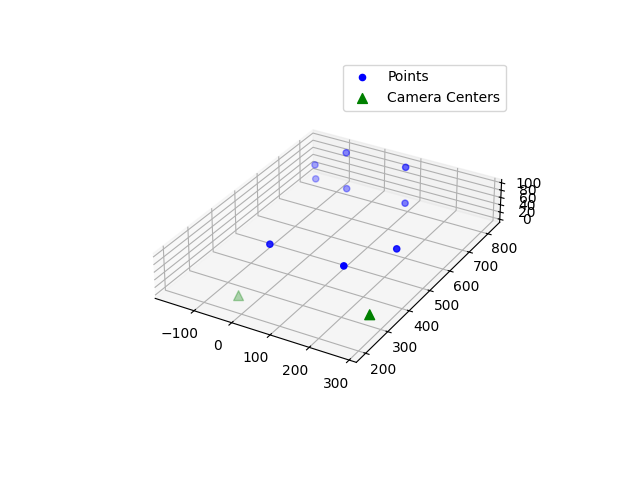

In [12]:
%matplotlib widget
# 3D point cloud for our background key points after triangulation creating point cloud
matches_custom = np.loadtxt('./custom_match.txt')
print(matches_custom.shape)
points_3d_gt = np.loadtxt('./futsal_court3d_' + str(fundamental_points) + '.txt')
points_3d_custom = triangulation(matches_custom, camera_proj1, camera_proj2) # <YOUR CODE>
res_3d_lab = evaluate_points_3d(points_3d_gt, points_3d_custom) # <YOUR CODE>
print('Mean 3D reconstuction error for the cam data: ', round(np.mean(res_3d_lab), 5))

custom_pt1 = matches_custom[:, :2]
custom_pt2 = matches_custom[:, 2:]
_, res_2d_custom1 = evaluate_points(camera_proj1, custom_pt1, points_3d_custom)
_, res_2d_custom2 = evaluate_points(camera_proj2, custom_pt2, points_3d_custom)
print('2D reprojection error for the cam 1 data: ', np.mean(res_2d_custom1))
print('2D reprojection error for the cam 2 data: ', np.mean(res_2d_custom2))
# point cloud visualized
camera_centers = np.vstack((camera1_c, camera2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_custom[:, 0], points_3d_custom[:, 1], points_3d_custom[:, 2], c='b', label='Points')
ax.scatter(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2], c='g', s=50, marker='^', label='Camera Centers')
ax.legend(loc='best')
ax.set_aspect('equal')

In [13]:
import json 
def load_keypoints(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    return [np.array(frame['keypoints'][0]) for frame in data if frame['keypoints']]


In [14]:
json_file1 = 'revised_videos/keypoints/IMG_0' + vid1 + '.json'
json_file2 = 'revised_videos/keypoints/IMG_' + vid2 + '.json'
keypoints1 = load_keypoints(json_file1)
keypoints2 = load_keypoints(json_file2)
pose3d = [] 
num_frames = min(len(keypoints1), len(keypoints2))
print(f"frame number is {num_frames}")
for f in range(num_frames):
    pose_keypoint_matches = np.c_[keypoints1[f], keypoints2[f]]
    pose3d.append(triangulation(pose_keypoint_matches, camera_proj1, camera_proj2))

#pose3d should have the shape (#frame, number of keypoints, 3)

frame number is 109


In [15]:
pose3d

[array([[-104.80898775,  377.28981864,   92.46320258],
        [-104.92377996,  377.40536403,   93.23507004],
        [-104.44906306,  376.87595542,   93.31414376],
        [-104.7174682 ,  376.79617755,   93.39313647],
        [-104.24521423,  376.11626595,   93.60450153],
        [-104.60500402,  376.81888818,   90.08678027],
        [-104.4030296 ,  376.63027325,   90.16178234],
        [-104.94068885,  377.59301225,   86.13311465],
        [-104.76514391,  377.43268307,   85.78130864],
        [-105.32964561,  378.34920634,   84.0285037 ],
        [-105.22479564,  378.25789355,   83.36077218],
        [-105.12068245,  377.9993895 ,   79.75019386],
        [-105.04376776,  377.93713282,   79.6564873 ],
        [-105.21978016,  378.45358628,   75.30208351],
        [-105.27719096,  378.56936822,   73.93895196],
        [-105.40958359,  379.09899498,   68.14075547],
        [-105.4188967 ,  379.11481271,   68.14862851]]),
 array([[-105.56154315,  378.7553106 ,   92.60229109],
        

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# Write your code here for triangulation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

Display the animation in just one frame

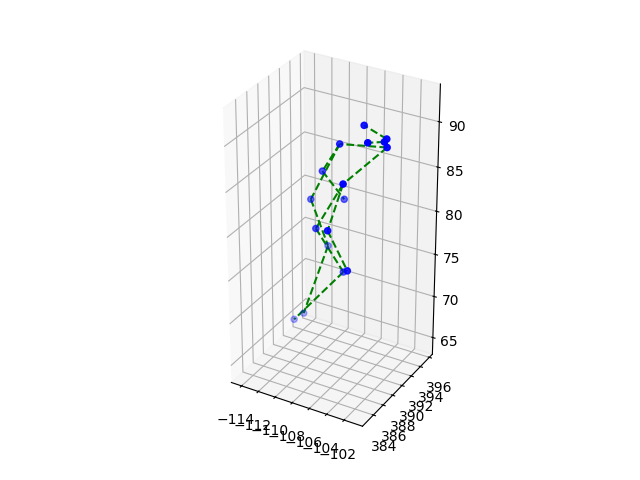

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
frame = 10
ax.scatter(pose3d[frame][:, 0], pose3d[frame][:, 1], pose3d[frame][:, 2], c='b', label='Points')
connections = [(0,1), (1,3), (0,2), (2,4), (0,5), (0,6), (5,7), (7,9), (6,8), (8,10), 
(5,11), (11,13), (13,15), (6,12), (12,14), (14,16)]

for start_idx, end_idx in connections:
    start_point = pose3d[frame][start_idx]
    end_point = pose3d[frame][end_idx]
    ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], [start_point[2], end_point[2]], color='green', linestyle='--')

ax.set_aspect('equal')

#### Part 5 Final Results and Visualization (Note there may be some index out of bounds error but this does not affect the visualization, at least when we are running it)

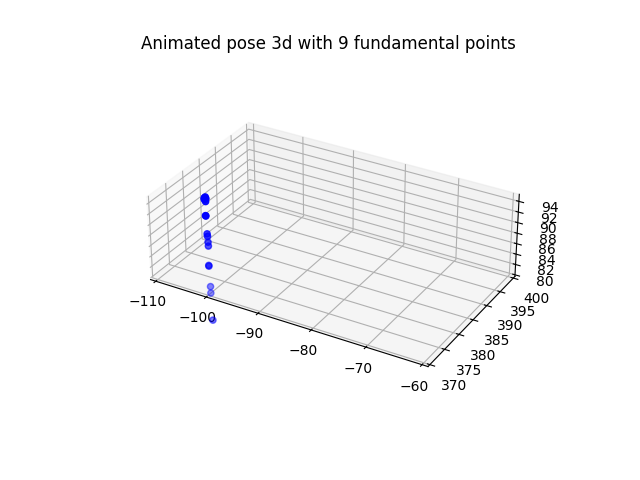

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Generate some sample data for demonstration
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initial frame
frame = 0
scat = ax.scatter(pose3d[frame][:, 0], pose3d[frame][:, 1], pose3d[frame][:, 2], c='b', label='Points')

# Define connections between points
connections = [(0, 1), (1, 3), (0, 2), (2, 4), (0, 5), (0, 6), (5, 7), (7, 9), (6, 8), (8, 10), 
               (5, 11), (11, 13), (13, 15), (6, 12), (12, 14), (14, 16)]

lines = [ax.plot([], [], [], color='green', linestyle='--')[0] for _ in range(len(connections))]

def update(frame):
    scat._offsets3d = (pose3d[frame][:, 0], pose3d[frame][:, 1], pose3d[frame][:, 2])
    for i, (start_idx, end_idx) in enumerate(connections):
        start_point = pose3d[frame][start_idx]
        end_point = pose3d[frame][end_idx]
        lines[i].set_data([start_point[0], end_point[0]], [start_point[1], end_point[1]])
        lines[i].set_3d_properties([start_point[2], end_point[2]])
    return scat, lines

x_min, x_max = -110, -60
y_min, y_max = 370, 400
z_min, z_max = 80, 95

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ax.set_title('Animated pose 3d with ' + str(fundamental_points) + " fundamental points")
ax.set_aspect('equal')
ani = FuncAnimation(fig, update, frames=100, interval=50)
plt.show()
ani.save('3d_pose_prototype' + vid1 + '_' + vid2 + '_' + str(fundamental_points) + '.mp4', writer='ffmpeg', fps=20)

#### Part 6: Post processing analysis

In [19]:
def find_avg_height(pose)

array([-95.74148085, 368.33878845,  81.8153491 ])